In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [159]:
class DataProcesser():
    def load_data(self, sales_path, prices_path, calendar_path):
        self.sales = pd.read_csv(sales_path)
        self.prices = pd.read_csv(prices_path)
        self.calendar = pd.read_csv(calendar_path)
        print('Data loaded')
    
    def get_holidays(self):
        calendar_data = self.calendar.copy()
        calendar_data['date'] = pd.to_datetime(calendar_data['date'])
        calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])
        holidays_data = calendar_data.dropna(subset=['event'])
        holidays = holidays_data[['date', 'event']]
        return holidays.rename(columns={'date': 'ds', 'event': 'holiday'})
    
    def get_processed_data(self, art):
        if not art:
            print('Specify item')
        self.data = pd.merge(pd.merge(self.calendar, self.sales, on='date_id'),
                             self.prices, 
                             on=['wm_yr_wk', 'store_id', 'item_id'], 
                             how='left')
        self.data.drop(axis=1,
                       columns=['wm_yr_wk',
                                'year',
                                'event_name_2',
                                'event_type_2',
                                'event_name_1',
                                'weekday',],
                        inplace=True)
        self.data = pd.get_dummies(self.data,
                              columns=['event_type_1'],
                              prefix='type',
                              dtype=int)
        self.data['is_weekend'] = self.data['wday'].apply(
            lambda x: 1 if x < 3 else 0)
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.rename(columns={'date': 'ds', 'cnt': 'y'})
        self.data = self.data[self.data.item_id==art]
        return self.data
    
    def get_split_data(self, data, test_size=90):
        train = data.iloc[:-test_size].copy()
        mean_sell_price = train['sell_price'].mean()
        train['sell_price'].fillna(mean_sell_price, inplace=True)
        test = data.iloc[-test_size:].copy()
        test['sell_price'].fillna(mean_sell_price, inplace=True)
        return train, test

In [160]:
class SalesForecaster():
    # def copy_data(self, sales, prices, calendar):
    #     self.sales = sales
    #     self.prices = prices
    #     self.calendar = calendar

    def train(self, data, holidays=None):
        self.data = data
        if holidays is None:
            self.model = Prophet()
        else:
            self.model = Prophet(holidays=holidays)
        self.model.add_regressor('CASHBACK_STORE_1')
        self.model.add_regressor('CASHBACK_STORE_2')
        self.model.add_regressor('CASHBACK_STORE_3')
        self.model.add_regressor('type_Cultural')
        self.model.add_regressor('type_Sporting')
        self.model.add_regressor('type_Religious')
        self.model.add_regressor('type_National')
        self.model.add_regressor('sell_price')
        self.model.fit(data)
        
    def predict(self, num_days, X_test):
        # future = self.model.make_future_dataframe(periods=len(X_test))
        future = pd.concat([self.data, X_test], axis=0, ignore_index=True)
        forecast = self.model.predict(future)
        return forecast.set_index('ds').loc[X_test['ds'], 'yhat']
    
    def get_metrics(self, y_true, y_pred):
        y_avg = y_true.mean()

        mae = mean_absolute_error(y_true, y_pred)
        print(f'MAE: {mae:.2f}')
        mse = mean_squared_error(y_true, y_pred)
        print(f'MSE: {mse:.2f}')
        print(f'MAE/avg: {mae / y_avg}')

        print('*' * 10)
        print('За месяц:')
        print('SUM test:',  y_true.sum())
        print('SUM predicted:',  y_pred.sum())
        print('SUM difference absolute', abs(y_true.sum() - y_pred.sum()))
        print('SUM difference %',
            round(abs(y_true.sum() - y_pred.sum()) / y_true.sum() * 100, 4))
    
    def plot_forecast(self, y_true, y_pred):
        plt.figure(figsize=(12, 6))
        # plt.plot(train['ds'], train['y'], label='Train')
        plt.plot(y_true['ds'], y_true['y'], label='Test')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        plt.show()

In [161]:
processer = DataProcesser()
processer.load_data(sales_path='../data/shop_sales.csv',
                   prices_path='../data/shop_sales_prices.csv',
                   calendar_path='../data/shop_sales_dates.csv')
holidays = processer.get_holidays()
data = processer.get_processed_data(art='STORE_2_085')
train, test = processer.get_split_data(data, test_size=90)

Data loaded


/tmp/ipykernel_26425/4096812741.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['sell_price'].fillna(mean_sell_price, inplace=True)
/tmp/ipykernel_26425/4096812741.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [162]:
forecaster = SalesForecaster()
forecaster.train(train, holidays=holidays)

04:46:32 - cmdstanpy - INFO - Chain [1] start processing
04:46:32 - cmdstanpy - INFO - Chain [1] done processing


In [163]:
y_pred = forecaster.predict(num_days=90, X_test=test)

forecaster.get_metrics(test['y'], y_pred)

MAE: 4.34
MSE: 30.23
MAE/avg: 0.5147010865356177
**********
За месяц:
SUM test: 759
SUM predicted: 816.7209113647334
SUM difference absolute 57.72091136473341
SUM difference % 7.6049


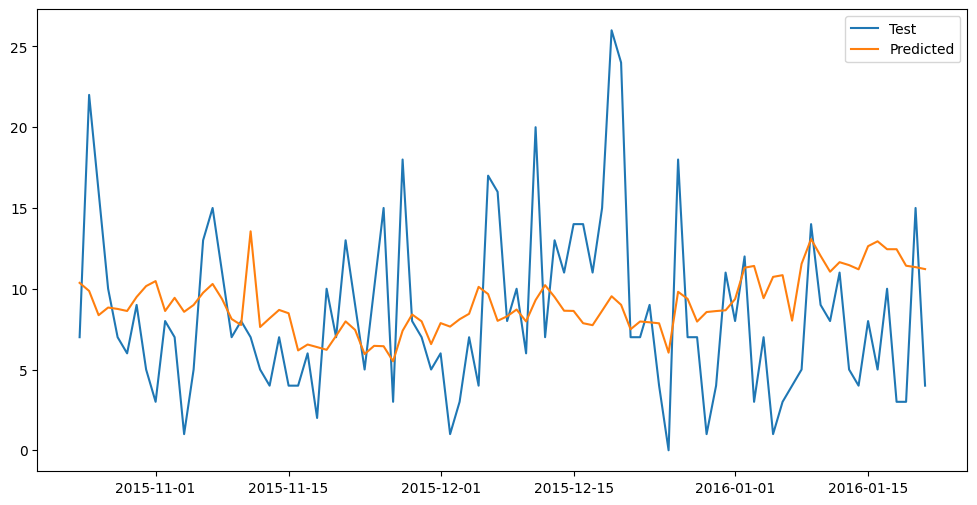

In [164]:
forecaster.plot_forecast(test, y_pred)

In [ ]:
fig = model.plot_components(y_pred)